<a href="https://colab.research.google.com/github/Meenalsh72/Envision/blob/main/envision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import plotly.colors
from datetime import datetime

In [2]:
df = pd.read_csv("/content/cleaned_processed_dataset_updated_2.csv")
df.head(2)

,Customer ID,Customer Name,Customer Location,Product Name,Product Actual Price,Product Discounted Price,Product Category,Purchase Date,Product ID
0,642185,Vritika,Bhopal,Adidas Ultraboost,2154,1524.29,Shoes,10-07-2021,7394904
1,786280,Elakshi,Bengaluru,Samsung Galaxy S23,97417,76515.11,Phones,23-12-2019,5421425


#Data Preprocessing



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               1979 non-null   int64  
 1   Customer Name             1979 non-null   object 
 2   Customer Location         1979 non-null   object 
 3   Product Name              1979 non-null   object 
 4   Product Actual Price      1979 non-null   int64  
 5   Product Discounted Price  1979 non-null   float64
 6   Product Category          1979 non-null   object 
 7   Purchase Date             1979 non-null   object 
 8   Product ID                1979 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 139.3+ KB




*  convert inovicedate to datetime
*  adding a column of totalamount



In [32]:
df.isnull().sum()

,0
Customer ID,0
Customer Name,0
Customer Location,0
Product Name,0
Product Actual Price,0
Product Discounted Price,0
Product Category,0
Purchase Date,0
Product ID,0


In [34]:
data = df.dropna(subset=['Customer ID', 'Purchase Date'])

In [36]:
# Correcting the date parsing with dayfirst=True
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], dayfirst=True)
df['Product Discounted Price'] = pd.to_numeric(df['Product Discounted Price'], errors='coerce')
# Verifying the changes
df['Purchase Date'].head()
df['Product Discounted Price']


,Product Discounted Price
0,1524.29
1,76515.11
2,768.67
3,2654.48
4,2640.52
...,...
1974,37002.86
1975,1144.68
1976,3323.75
1977,6227.24


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Customer ID               1979 non-null   int64         
 1   Customer Name             1979 non-null   object        
 2   Customer Location         1979 non-null   object        
 3   Product Name              1979 non-null   object        
 4   Product Actual Price      1979 non-null   int64         
 5   Product Discounted Price  1979 non-null   float64       
 6   Product Category          1979 non-null   object        
 7   Purchase Date             1979 non-null   datetime64[ns]
 8   Product ID                1979 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 139.3+ KB


#Calculating RFM score

In [9]:
reference_date = pd.Timestamp(datetime.now().date())
print(reference_date)  # Example output: 2024-12-19 00:00:00

2025-01-20 00:00:00


Creating a dataframe names as 'rfm' which calculates Recency, frequncy and Monetary by grouping the data wrt to customer id from the data table

In [13]:
rfm = df.groupby('Customer ID').agg({
    'Purchase Date': lambda x: (reference_date - x.max()).days,  # Recency: Days since last purchase
    'Product ID': 'count',  # Frequency: Count of purchases
    'Product Discounted Price': 'sum'  # Monetary: Total spent
}).rename(columns={
    'Purchase Date': 'Recency',
    'Product ID': 'Frequency',
    'Product Discounted Price': 'Monetary'
})

Renaming column names in rfm dataframe as Recency, Frequency and Monetary



In the given code, RFM (Recency, Frequency, Monetary) scores are calculated to evaluate customer behavior. First, the data is divided into three features: Recency (days since last purchase), Frequency (number of purchases), and Monetary (total spending). The quantiles (25%, 50%, and 75%) for each feature are calculated to create thresholds for scoring. The RScore function assigns scores based on these quantiles, where customers with values closer to the lower quartile receive a lower score and those closer to the higher quartile receive a higher score. The scores for each feature (R, F, M) are then applied to the customer data, providing an overall assessment of customer behavior based on their recency, frequency, and spending habits.

In [14]:
# Define quantiles
quantiles = rfm.quantile(q=[0.25, 0.50, 0.75])

# Assign RFM scores
def RScore(x, p, d):
    if p == 'Recency':
        if x <= d[p][0.25]:
            return 4
        elif x <= d[p][0.50]:
            return 3
        elif x <= d[p][0.75]:
            return 2
        else:
            return 1
    else:  # For Frequency and Monetary
        if x <= d[p][0.25]:
            return 1
        elif x <= d[p][0.50]:
            return 2
        elif x <= d[p][0.75]:
            return 3
        else:
            return 4

# Apply RFM scoring
rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency', quantiles,))
rfm['F'] = rfm['Frequency'].apply(RScore, args=('Frequency', quantiles,))
rfm['M'] = rfm['Monetary'].apply(RScore, args=('Monetary', quantiles,))

# Review the updated DataFrame
rfm

,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
100027,456,1,4160.05,3,1,2
100636,340,1,4297.47,4,1,2
100848,1911,1,42115.34,1,1,3
102744,1196,2,4153.44,2,3,2
104228,70,1,2310.86,4,1,1
...,...,...,...,...,...,...
998247,220,1,1327.52,4,1,1
999111,1823,1,38183.83,1,1,3
999351,232,3,103334.83,4,4,4


Segmenting customers based on RScore as low, medium, and high-value customers.

In [15]:
# Ensure R, F, and M columns are integers
rfm['R'] = rfm['R'].fillna(0).astype(int)
rfm['F'] = rfm['F'].fillna(0).astype(int)
rfm['M'] = rfm['M'].fillna(0).astype(int)

# Create the 'segments' column by concatenating R, F, and M as strings
rfm['segments'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Create the 'Score' column by summing R, F, and M
rfm['Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

# Review the updated DataFrame
rfm.head()

,Recency,Frequency,Monetary,R,F,M,segments,Score
Customer ID,,,,,,,,
100027,456,1,4160.05,3,1,2,312,6
100636,340,1,4297.47,4,1,2,412,7
100848,1911,1,42115.34,1,1,3,113,5
102744,1196,2,4153.44,2,3,2,232,7
104228,70,1,2310.86,4,1,1,411,6


In [41]:
segment_labels = ['Low—Value', 'Mid—Vatue', 'High—Value']
def assign_segment(score):
    if score < 5:
        return 'Low-Value'
    elif score < 9:
        return 'Mid-Value'
    else:
        return 'High-Vatue'

rfm['rfm_segment_labels'] = rfm['Score'].apply(assign_segment)
rfm.head()


,Recency,Frequency,Monetary,R,F,M,segments,Score,rfm_segment_labels,RFM_Customer_segments
Customer ID,,,,,,,,,,
100027,456,1,4160.05,3,1,2,312,6,Mid-Value,Potential Loyal
100636,340,1,4297.47,4,1,2,412,7,Mid-Value,Potential Loyal
100848,1911,1,42115.34,1,1,3,113,5,Mid-Value,At Risk Customers
102744,1196,2,4153.44,2,3,2,232,7,Mid-Value,Potential Loyal
104228,70,1,2310.86,4,1,1,411,6,Mid-Value,Potential Loyal



Counting the number of customers in each segment.


In [18]:
# Count the occurrences of each RFM segment label
segments_counts = rfm['rfm_segment_labels'].value_counts().reset_index()

# Rename the columns for clarity
segments_counts.columns = ['RFM_segment', 'Count']

# Sort by the 'RFM_segment' column
segments_counts = segments_counts.sort_values('Count')
segments_counts

,RFM_segment,Count
2,Low-Value,256
1,High-Vatue,388
0,Mid-Value,603



Analyzing the number of customers falling in each segment with the help of a bar chart.

In [53]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,segments,Score,rfm_segment_labels,RFM_Customer_segments
Customer ID,,,,,,,,,,
100027,456,1,4160.05,3,1,2,312,6,Mid-Value,Potential Loyal
100636,340,1,4297.47,4,1,2,412,7,Mid-Value,Potential Loyal
100848,1911,1,42115.34,1,1,3,113,5,Mid-Value,At Risk Customers
102744,1196,2,4153.44,2,3,2,232,7,Mid-Value,Potential Loyal
104228,70,1,2310.86,4,1,1,411,6,Mid-Value,Potential Loyal


In [54]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1247 entries, 100027 to 999853
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Recency                1247 non-null   int64  
 1   Frequency              1247 non-null   int64  
 2   Monetary               1247 non-null   float64
 3   R                      1247 non-null   int64  
 4   F                      1247 non-null   int64  
 5   M                      1247 non-null   int64  
 6   segments               1247 non-null   object 
 7   Score                  1247 non-null   int64  
 8   rfm_segment_labels     1247 non-null   object 
 9   RFM_Customer_segments  1247 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 107.2+ KB


In [19]:
import plotly.express as px

# Create a bar chart using Plotly Express
fig = px.bar(segments_counts,
             x='RFM_segment',          # The RFM segment column for the x-axis
             y='Count',                # The count column for the y-axis
             title='Customer Distribution by RFM segment',  # Title of the chart
             labels={'RFM_segment': 'RFM Segment', 'Count': 'Number of Customers'},  # Axis labels
             color='RFM_segment',      # Corrected color argument
             color_discrete_sequence=px.colors.qualitative.Pastel)  # Color palette

# Show the plot
fig.show()

Segmenting customers further into five categories based on RFM score: VIP/Loyal, Potential Loyal, At Risk, Can't Lose, and Lost. Also Counting the number of customers in each segment to analyze engagement levels and tailor marketing strategies.

In [20]:
rfm['RFM_Customer_segments'] = ''
rfm.loc[rfm['Score'] >=9, 'RFM_Customer_segments'] = 'VIP/Loyal'
rfm.loc[(rfm['Score'] >=6) & (rfm['Score'] <9) , 'RFM_Customer_segments'] = 'Potential Loyal'
rfm.loc[(rfm['Score'] >=5) & (rfm['Score'] <6) , 'RFM_Customer_segments'] = 'At Risk Customers'
rfm.loc[(rfm['Score'] >=4) & (rfm['Score'] <5) , 'RFM_Customer_segments'] = 'Can\'t Lose'
rfm.loc[(rfm['Score'] >=3) & (rfm['Score'] <4) , 'RFM_Customer_segments'] = 'Lost'
segments_counts = rfm['RFM_Customer_segments'].value_counts().sort_index()

here counting the combinations of rfm_segment_labels and RFM_Customer_segments, showing how many customers fall into each combination. It then sorts the results to display the most common combinations first.

In [21]:
segment_product_counts = rfm.groupby(['rfm_segment_labels', 'RFM_Customer_segments']).size().reset_index(name = 'Count')
segment_product_counts = segment_product_counts.sort_values('Count', ascending = False)

creating a treemap to display the distribution of customers across different combinations of rfm_segment_labels and RFM_Customer_segments. It shows the count of customers in each combination, uses different colors for each rfm_segment_labels.

In [22]:
fig_treemap_segment_product = px.treemap(segment_product_counts,
                                         path=['rfm_segment_labels', 'RFM_Customer_segments'],
                                         values = 'Count',
                                         color = 'rfm_segment_labels',
                                         color_discrete_sequence = px.colors.qualitative.Pastel,
                                         title='RFM Customer Segemtns by values')
fig_treemap_segment_product.show()

visualizing the distribution for the VIP/Loyal segment but why VIP/Loyal segment?

Targeted Analysis: Focuses on VIP/Loyal customers to identify unique behaviors, as they are highly valuable.
Retention Strategies: Helps design strategies to retain and engage this group.
Marketing Insights: Provides insights to encourage frequent purchases if Monetary value is high but Recency is low.
(Similar analysis can be conducted for different segments to understand their distribution and tailor customized strategies for them.)

In [23]:
vip_segment = rfm[rfm['RFM_Customer_segments']== 'VIP/Loyal']

In [27]:

fig = go.Figure()
fig.add_trace(go.Box(y=vip_segment['Recency'], name='Recency'))
fig.add_trace(go.Box(y=vip_segment['Frequency'], name='Frequency'))
fig.add_trace(go.Box(y=vip_segment['Monetary'], name='Monetary'))
fig.update_layout(
    yaxis=dict(range=[0, 100000])
)
fig.show()

The correlation matrix helps analyze relationships between Recency, Frequency, and Monetary values for VIP/Loyal customers. Understanding these correlations provides insights to refine strategies and enhance engagement with this valuable segment.

In [28]:
correlation_matrix = vip_segment[['R','F','M']].corr()

Creating a heatmap of the correlation matrix visualizes the relationships between Recency, Frequency, and Monetary values for the VIP/Loyal (Champion) segment. This helps identify strong or weak correlations, making it easier to interpret patterns and dependencies that can guide targeted decision-making for this valuable customer group.

In [29]:
fig_heatmap = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='RdBu',
    colorbar=dict(title='Correlation')
))

fig_heatmap.update_layout(title='Correlation Matrix of RFM Values within VIP/Loyal segments')
fig_heatmap.show()

creating a bar chart comparing the number of customers in different RFM segments. The VIP/Loyal (Champions) segment is highlighted in a distinct color to emphasize its significance. The visualization helps analyze segment distributions and identify high-priority customer groups, aiding in strategic focus and resource allocation.

In [30]:
pastel_colors = plotly.colors.qualitative.Pastel
fig = go.Figure(data = [go.Bar(x=segments_counts.index, y=segments_counts.values,
                               marker = dict(color=pastel_colors))])
vip_color = 'rgb(158,202,225)'
fig.update_traces(marker_color=[vip_color if segment == 'Champions' else pastel_colors[i]
                                for i, segment in enumerate(segments_counts.index) ],
                   marker_line_color = 'rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title='Comparision of RFM Segments',
                  xaxis_title='RFM Segmentd',
                  yaxis_title='Number of Customers',
                  showlegend=False)
fig.show()

A grouped bar chart to compare the average Recency, Frequency, and Monetary scores for each RFM customer segment. Each bar represents the average score for one of the RFM dimensions within a specific segment, providing insights into how customer behavior differs across segments. This analysis helps identify the strengths and weaknesses of each segment, guiding targeted marketing and engagement strategies.

In [31]:
segment_scores = rfm.groupby('RFM_Customer_segments')[['R','F','M']].mean().reset_index()
fig = go.Figure()

#Add bars for Recency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM_Customer_segments'],
    y=segment_scores['R'],
    name='Recency Score',
    marker_color='rgb(158,202,225)'

))
#Add bars for Frequency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM_Customer_segments'],
    y=segment_scores['F'],
    name='Frequency Score',
    marker_color='rgb(94,158,217)'

))
#Add bars for Monetary score
fig.add_trace(go.Bar(
    x=segment_scores['RFM_Customer_segments'],
    y=segment_scores['M'],
    name='Monetary Score',
    marker_color='rgb(32,102,148)'

))

#update the layout
fig.update_layout(
    title='Comaprision of RFM Segment based on Recency, Frequency, and Monetary Scores',
    xaxis_title='RFM Segments',
    yaxis_title='Score',
    barmode='group',
    showlegend=True
)

fig.show()

#Data Visualizations


#Pair Plot Analysis


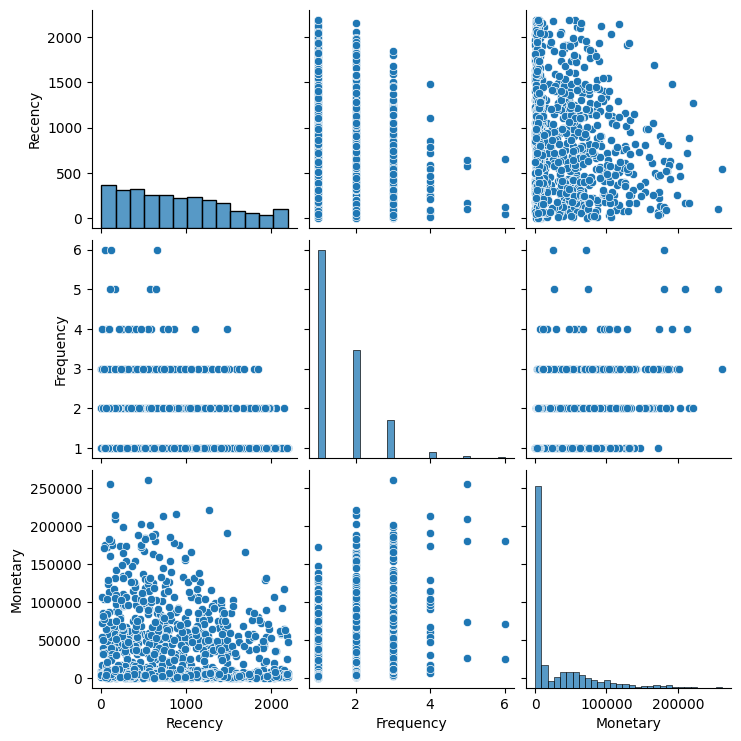

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary']])
plt.show()


Box Plot for outliers detection

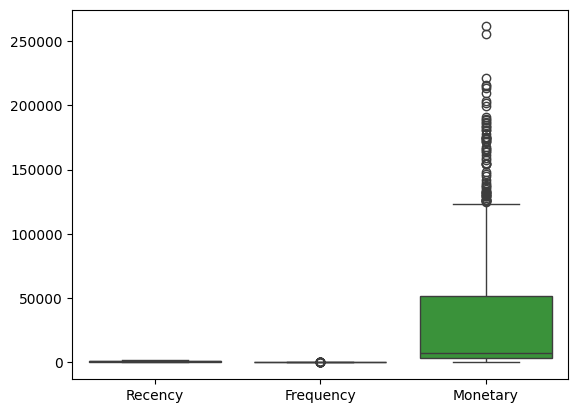

Recency       0
Frequency    29
Monetary     70
dtype: int64


In [45]:
# Boxplots for outlier detection
sns.boxplot(data=rfm[['Recency', 'Frequency', 'Monetary']])
plt.show()

# Optional: Detect outliers using IQR
Q1 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.25)
Q3 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.75)
IQR = Q3 - Q1

# Aligning indices
outliers = (rfm[['Recency', 'Frequency', 'Monetary']] < (Q1 - 1.5 * IQR)) | \
           (rfm[['Recency', 'Frequency', 'Monetary']] > (Q3 + 1.5 * IQR))

print(outliers.sum())  # Count of outliers per feature



#correlation map for feature dependencies

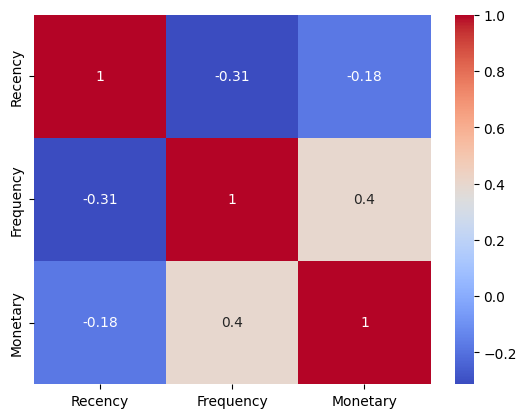

In [47]:
# Correlation heatmap
corr = rfm[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


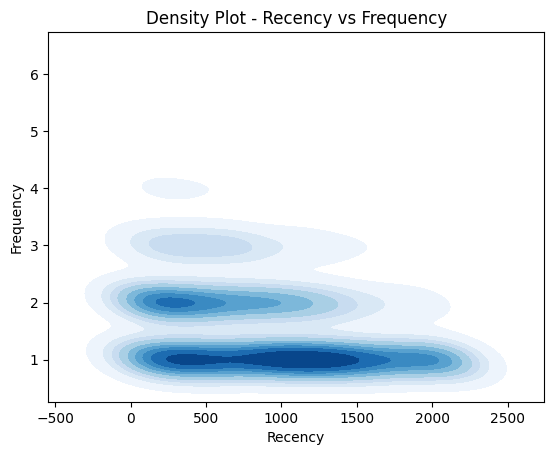

In [51]:
sns.kdeplot(
    x=rfm['Recency'],
    y=rfm['Frequency'],
    cmap="Blues",
    fill=True
)
plt.title('Density Plot - Recency vs Frequency')
plt.show()




#Data Modelling

Using DBSCAN here since data has significant outliers and is dense